#  Анализ и подготовка плана действий по удержанию клиентов сети фитнес-центров «Культурист-датасаентист»

Мы разрабатываем стратегию взаимодействия с клиентами на основе аналитических данных. Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.  

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.  

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Наша задача — провести анализ и подготовить план действий по удержанию клиентов.

**План действий:**  
* Научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* Проанализировать основные признаки, наиболее сильно влияющие на отток;
* Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
 1) выделить целевые группы клиентов;
 2) предложить меры по снижению оттока;
 3) определить другие особенности взаимодействия с клиентами.

**Какие шаги были проделаны:**

1. Загрузка и подготовка данных
2. Исследовательский анализ данных (EDA)
3. Построение модели програнзирования оттока клиентов
4. Кластеризация клиетов 
5. Вывод с рекомендациями

## Зарузка и подготовка данных

In [1]:
# Импортируем необходимые библиотеки

import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import itertools
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

In [2]:
# Загрузим датасет и выведем первые 5 строк

try:
    df = pd.read_csv('/Users/alekseivlasov/Desktop/project/11/gym_churn.csv')
except:
    df = pd.read_csv('/datasets/gym_churn.csv')
    
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
# Сразу округлим числовые значения до сотых
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
# Просмотрим общую информацию и размер датасета

print(df.shape)
df.info()

(4000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-n

У нас в таблице 4000 сторок и 14 столбцов, название нужно привести к правильному стилю  
Пропусков не обнаружено и с типами данных тоже все хорошо

In [5]:
# Переведем названия колонок в нижний регистр
df.columns = df.columns.str.lower()
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Привели название к правильному стилю и округлили числовые значения до сотых, теперь датасет готов для дальнейшего исследования

## Исследовательский анализ данных (EDA)

Пропуски в датасете не обнаружены, теперь изучим средние значения и стандартное отклонение

In [6]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


Большая часть клиентов живет в  близости от фитнес-центров, об этом говорит высокое срднее и низкое стандартное отклонение. Половина клиентов пришла по партнерским программам, среди клиентов менее половины тех, кто пришел по акции "приведи друга", почти у всех указан номер телефона, менее половины посещают групповые занятия (видимо предпочитая заниматься самостоятельно).  
Средний возраст клиента составляет 29-30 лет. Абонементы бывают от 1 до 12 месяцев и судя по стандартному отклонению разброс этих абонементов довольно большой. То же касается и срока окончания действия абонементов.  
Есть клиенты, которые еще ни разу не успели посетить занятия и те, кто занимается уже более 2-х лет. Есть "бойцы", которые занимаются по 6 раз в неделю, но в среднем это 1-2 посещения в неделю. Максимальная выручка с допуслуг в центрах более 550 единиц валюты, в среднем 147. Отток на первый взгляд выглядит не катастрофическим, в среднем 26%

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [7]:
df.groupby('churn').mean().T

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


В оттоке мы видимо, что пол не влияет на этот показатель. Это клиенты, кто приходят не по партнерской программе, занимаются в среднем 1 месяц и живут не близко от фитнес-центра   
Групповые занятия посещают в 2 раза реже, чем те, кто не ушел и частоста посещений в неделю тоже в 2 раза меньше

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался

In [8]:
# Начнем с колличественных признаков 
quantitative = df[['age', 'avg_additional_charges_total', 'month_to_end_contract', 
                         'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']]
quantitative.shape

(4000, 6)

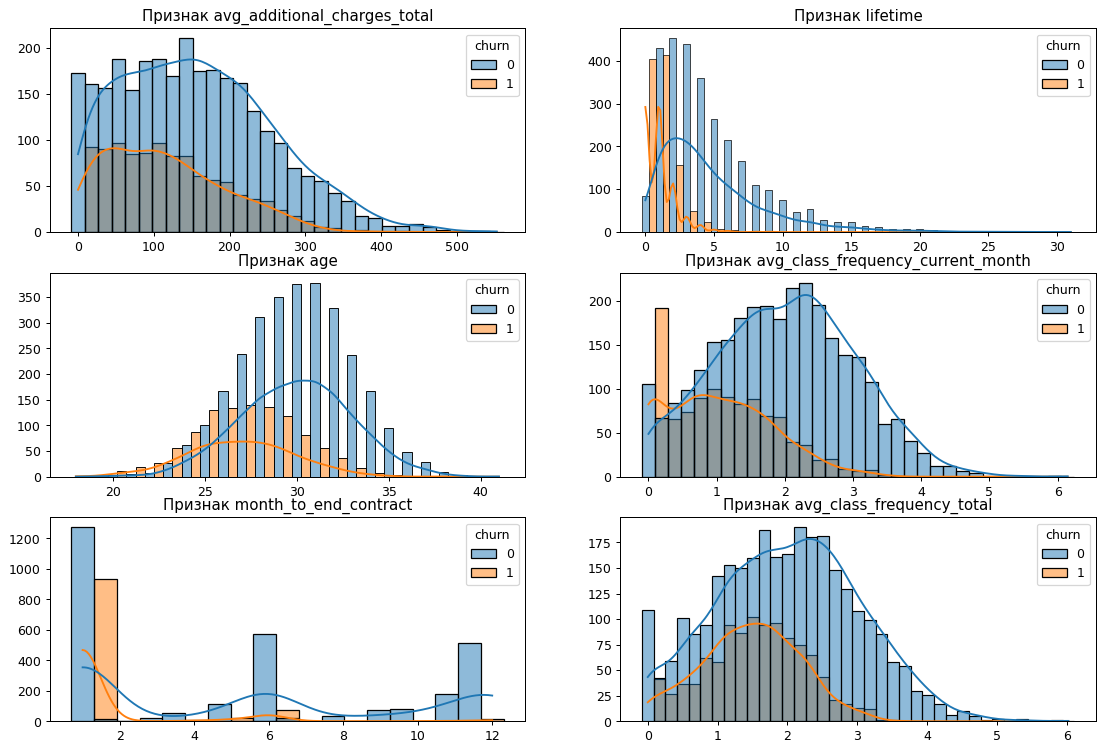

In [9]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,10), dpi=90)
 
features = list(set(quantitative.columns))
for idx, feat in  enumerate(features):
    sns.histplot(data = df, x=feat, hue='churn', multiple="dodge", kde = True, shrink=2, ax=axes[idx // 2, idx % 2]).set(
        title='Признак ' + feat)
    axes[idx // 2, idx % 2].set_ylabel('')
    axes[idx // 2, idx % 2].set_xlabel('');

In [10]:
# Соберем категориальные признаки
categorical = df[['gender', 'near_location', 'partner', 'promo_friends',
                  'phone', 'contract_period', 'group_visits']]

categorical.shape

(4000, 7)

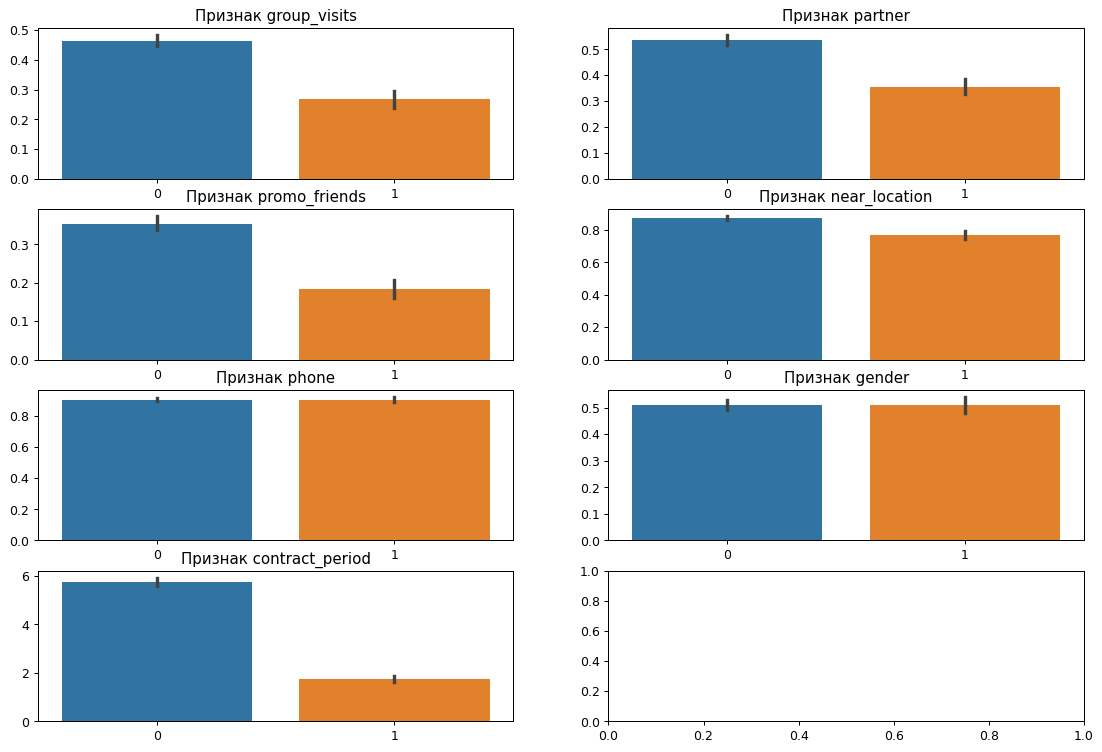

In [11]:
# Построим графики

f, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,10), dpi=90)
 
features = list(set(categorical.columns))
for idx, feat in  enumerate(features):
    sns.barplot(y=feat, x=df['churn'], data=df, ax=axes[idx // 2, idx % 2]).set(
        title='Признак ' + feat)
    axes[idx // 2, idx % 2].set_ylabel('')
    axes[idx // 2, idx % 2].set_xlabel('');

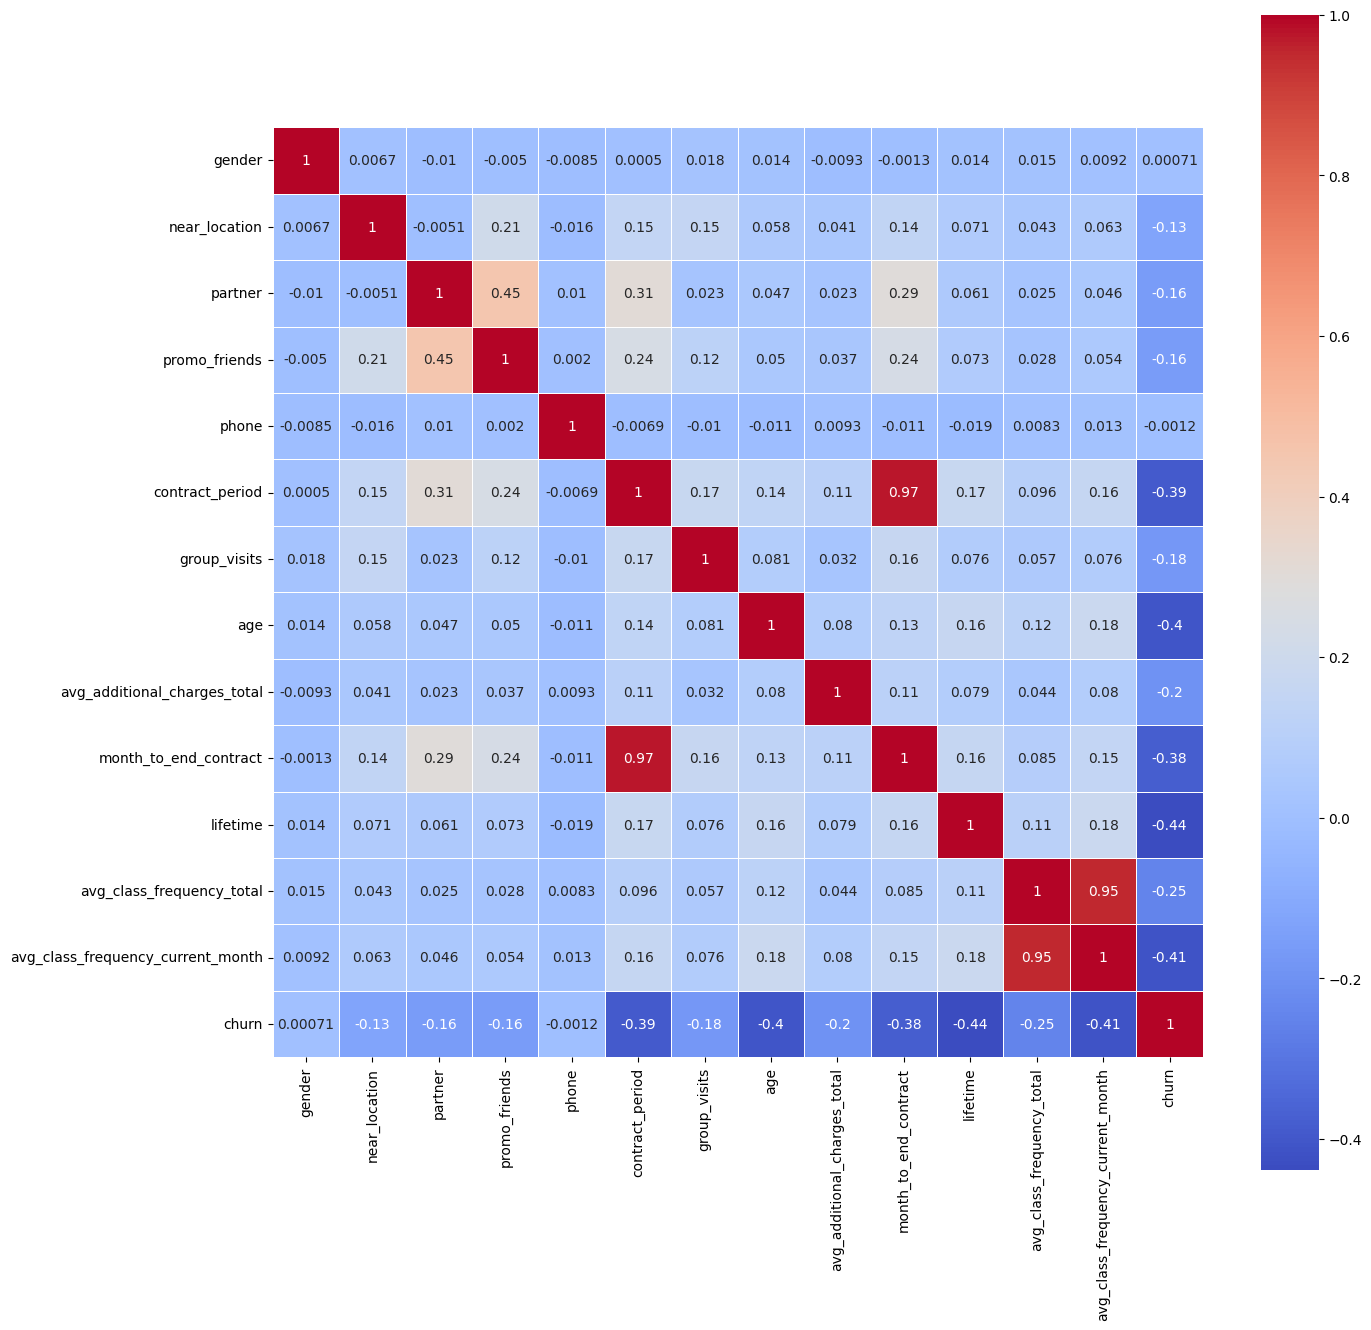

In [12]:
# Построим матрицу корреляций
cm = df.corr()
fig, ax = plt.subplots(figsize=[15,15])
sns.heatmap(cm, annot=True, square=True, linewidths=.5, cmap='coolwarm')
plt.show()

Есть мультиколлинеарные признаки - ``contract_period`` и ``month_to_end_contract``, ``avg_class_frequency_current_month`` и ``avg_class_frequency_total``. Один из признаков в каждой паре нужно удалить  
Есть признаки с нулевой корреляцией с целевой переменной, это phone и gender, они вообще никак не влияют на отток. Наиболее сильно влияют на отток: время с момента первого обращения в фитнес-центр, количество псещений в месяц, возраст, длительность текущего действующего абонемента ну и в конце этого топа наличие скидок по партнерской программе или факт, что клиента пригласил друг.

In [13]:
df = df.drop(columns=['month_to_end_contract', 'avg_class_frequency_current_month'])
df.shape

(4000, 12)

**Вывод:**
Мы завершили исследовательский аналих данных (EDA)
* Проверили датасет на пропуски
* Изучили средние значения и страндартные отклонения
* Построили столбчатые гистрограммы 
* Построили матрицу корреляций и удалили признаки с сильной корреляцией


## Модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце

In [14]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(columns=['churn'])
y = df['churn']

# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# преобразуем обучающий и валидационный наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [15]:
# зададим алгоритм для нашей модели, начнем с логической регрессии
model = LogisticRegression(random_state=0)

# обучим модель
model.fit(X_train_st, y_train)

# сделаем прогнозы 
predictions = model.predict(X_test_st)
probabilities = model.predict_proba(X_test_st)[:,1]

# выведим метрики для полученного прогноза
print('Метрики логической регргессии:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
print()

# зададим алгоритм модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)

# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

# выведим метрики для полученного прогноза
print('Метрики случайного леса:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))

Метрики логической регргессии:
Accuracy: 0.91
Precision: 0.83
Recall: 0.83

Метрики случайного леса:
Accuracy: 0.89
Precision: 0.81
Recall: 0.79


**Вывод:**  
* Мы построили 2 модели програнзирования оттока клиентов, с помощью алгоритмов: Логической регрессии и случайного леса  
* Оценили метрики: accuracy, precision и recall  
* Логическая регрессия показала себя лучше на основании метрик

## Кластеризация клиентов

Для начала стандартизируем данные

In [16]:
x_sc = scaler.fit_transform(df.drop(columns = ['churn'])) # обучаем нормализатор и преобразуем набор данных 
x_sc

array([[ 0.97970588,  0.42788074,  1.02686062, ..., -1.37753121,
        -0.19332863, -1.91191971],
       [-1.0207145 ,  0.42788074, -0.973842  , ..., -0.35021325,
         0.87368001,  0.04517569],
       [-1.0207145 ,  0.42788074,  1.02686062, ..., -0.1815923 ,
        -0.46008079, -0.02049263],
       ...,
       [ 0.97970588,  0.42788074,  1.02686062, ..., -0.71300239,
        -0.46008079,  0.93313947],
       [-1.0207145 ,  0.42788074,  1.02686062, ..., -0.88258181,
        -0.19332863, -0.25604937],
       [ 0.97970588, -2.33709981,  1.02686062, ...,  0.33129445,
        -0.72683295, -0.79947418]])

Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму

In [ ]:
linked = linkage(x_sc, method = 'ward')
plt.figure(figsize=(15,10))
dendrogram(linked, orientation = 'top')
plt.title('Иерархическая кластеризация')
plt.show()

На основании полученного графика, оптимальное число кластеров 5 — пять разных цветов на графике

Обучим модель кластеризации на основании алгоритма K-Means

In [ ]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters = 5, random_state = 0)

# прогнозируем кластеры для наблюдений 
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
df['cluster'] = labels

Посмотрим на средние значения признаков для кластеров

In [ ]:
# посмотрим на численность кластеров
df.cluster.value_counts()

In [ ]:
df.groupby('cluster').mean().T

In [ ]:
cluster_features = df.groupby('cluster').mean().reset_index()
numeric_columns = cluster_features.drop(columns=['cluster']).columns
cluster_features.style.format({i: '{:.2f}' for i in numeric_columns}) \
    .highlight_max(color='yellowgreen', subset=numeric_columns) \
    .highlight_min(color='coral', subset=numeric_columns)

Самым многочисленным кластером является 2-ой, затем идет 1-ый. Самый малочисленный - 4-ый. Самый большой отток в 0-м кластере - 40%, затем во 2-м - 38%. 1-ый кластер выглядит самым устойчивым - он второй по многочисленности (1050 чел.) и в нем маленький отток, всего 12%.

Признаки самых лучших кластеров по показателю оттока: по половому признаку распределены примерно поровну, в основном живут недалеко, часто приходят по партнерской акции или приглашению друзей, почти в половине случаев посещают групповые занятия, их возраст около 30 лет и жизнь клиента около 4 месяцев.

**Нулевой кластер**  
Мы видим янвую проблему данного кластера, что расстояние до фитнес-центра большое, клиенты не местные, что как раз и сказывается на оттоке

**Первый кластер**  
В данном случае ситация противоположенная, клиенты живут рядом, что позитивно сказывается на ходьбе в фитнес-центр. Также видно, что клиенты приходят чаще всего по партнерским программам и по промокодам. Они берут длительные абонементы, это говорит о решительности ходить в зал  

**Второй кластер**  
Во втором кластере клиенты не посещают групповые занятия, что видимо негативно сказывается на состоянии, и человек без поддержки и командной работы быстрее прекращает тренироваться  

**Третий кластер**  
Эта группа клиентов постоянно ходит на групповые занятия, что хорошо сказывается, чтобы клиент не переставал ходить в зал  

**Четвертый кластер**  
Интересное наблюдение, клиенты в четвертом кластере не любят оставлять контактный телефон 

Построим распределения признаков для кластеров

In [ ]:
# Начнем с количественных признаков, нужно убрать признаки, которые мы удалил из датасета
quantitative = quantitative.drop(columns=['month_to_end_contract', 'avg_class_frequency_current_month'])

In [ ]:
# Построим график
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10), dpi=90)
 
features = list(set(quantitative.columns))
for idx, feat in  enumerate(features):
    sns.histplot(data = df, x=feat, hue='cluster', multiple="dodge",
                 shrink=2, kde = True, palette='rainbow', ax=axes[idx // 2, idx % 2]).set(
        title='Признак ' + feat)
    axes[idx // 2, idx % 2].set_ylabel('')
    axes[idx // 2, idx % 2].set_xlabel('');

In [ ]:
# Теперь построим графики для категориальных признаков

f, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,10), dpi=90)
 
features = list(set(categorical.columns))
for idx, feat in  enumerate(features):
    sns.barplot(y=feat, x=df['cluster'], data=df, ax=axes[idx // 2, idx % 2]).set(
        title='Признак ' + feat)
    axes[idx // 2, idx % 2].set_ylabel('')
    axes[idx // 2, idx % 2].set_xlabel('');

In [ ]:
#посмотрим средние значения оттока в кластерах
df.groupby('cluster').agg({'churn':'mean'}).sort_values(by='churn')

**Вывод:**

Тут так же подтверждается, что самый большой отток в 0-м кластере - 40%, затем во 2-м - 38%  
1-ый кластер выглядит самым устойчивым - он второй по многочисленности (1050 чел.) и в нем маленький отток, всего 12%

## Общий вывод

Мы завершили исследование по оттоку клиентов, пора подвести итоги

* У нас есть портрет идеального среднестатистического клиента: ему около 30 лет, он живет неподалеку от фитнес-центра, любит посещать групповые занятия, у него есть друзья, которые хотят в тот же фитнес-центр и есть скидки/бонусы по каким-то программам. У него абонемент на пол года или более и ходит 2 раза в неделю

* Чаще всего в отток попадают клиенты, которые, похоже, пришли попробовать позаниматься в зале, но что-то их не устроило. Это клиенты с признками как правило противоположными "идеальному" случаю. Либо живут не так близко, либо не посещают групповые занятия или пришли не по клиентской бонусной программе. Они берут абонемент на месяц, редко посещают тренировки. Таким клиентам стоит предложить какие-то "плюшки" и уделять особое внимание, чтобы увеличить их лояльность. Как вариант - сделать им "вкусное" предложение на несколько бесплатных групповых занятий, где они смогут почувствовать эффект от занятий с тренером и другими людьми, возможно, завести новых друзей и у них будет больше мотивации посещать зал. Так же предположительно можно предлагать им специальные бонусные программы.

* Среди клиентов удалось определить 4-5 явных кластеров. В данном случае первый кластер выглядит самым устойчивым - он второй по многочисленности (1050 чел.) и в нем маленький отток, всего 12%. Следовательно, этот кластер является самыми прибыльным.

* Срок жизни ощутимо влияет на доход от клиента, поэтому стоит подумать о том, чтобы увеличить этот показатель во всех группах.

* С алгоритмом прогнозирования оттока все предельно просто, на этих данных отлично справляется логистическая регрессия, с большой долей вероятности она правильно предскажет возможный отток клиента, точность будет более 90%